# IA006 - EFC01
# UNICAMP

## 229990 - Vítor Yudi Shinohara
## Tópico: Regressão Linear


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Constante de número de folds
FOLDS_NUMBER = 5

In [3]:
def generate_phi(data, K):
    phi = []
    for i in range(len(data) - K):
        # Flip para pegar os valores de sunspots mais recentes
        phi_x = np.flip(data[i:i + K])
        # Adiciona phi_x na matriz phi
        phi.append(phi_x)
    return np.array(phi)

def generate_y(data, K):
    y = []
    for i in range(K, len(data)):
        y.append(data[i])
    return y

In [4]:
def predict_x_next(train_subset, test_subset, w, X, K, idxs_to_remove=None):
    predicted_values = []

    for i in range(X):
        features = np.flip(train_subset[i:])
        
        if idxs_to_remove != None:
            for j in idxs_to_remove:
                features = np.delete(features, j)
        
        features = np.insert(features, 0, 1).T

        predicted_value = np.dot(features, w)    
        
        train_subset = np.append(train_subset, test_subset[i])
        
        predicted_values.append(predicted_value)
        
        
        
    return predicted_values

In [5]:
def k_fold(x, y, k):
    
    if len(x) != len(y):
        print('X and Y must have the same shape.')
        print('X have shape of {} and Y have shape {}'.format(x.shape, y.shape))
        return None
    
    elements_per_fold = len(x) / k
    
    x_folds, y_folds = [], []
    for i in range(k):
        x_fold = x[i * elements_per_fold: (i+1) * elements_per_fold]
        y_fold = y[i * elements_per_fold: (i+1) * elements_per_fold]
        x_folds.append(x_fold)
        y_folds.append(y_fold)
    
    return x_folds, y_folds

In [6]:
def compute_error_k_fold(x, y, alpha):
    # Função lambda para calcular o RMSE
    rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum((predictions - sunspots_values_test)**2) /len(predictions))
    # Lista para computar o histórico de erro
    error_hist = []
    folds_number = len(x)
    
    # Itera sobre os folds de validação
    for validation_index in range(folds_number):
        
        x_train, y_train, x_validation, y_validation = [], [], [], []
        # Itera sobre os folds de teste
        for train_index in range(folds_number):
            # Se o indice do fold de validação é igual ao índice de teste:
            
            if validation_index == train_index:
                # Cria o conjunto de validação
                x_validation = x[validation_index]
                # Adiciona o bias
                x_validation = np.insert(x_validation, 0, 1, axis=1)
                # Obtem os labels do conjunto de validação
                y_validation = y[validation_index]
                continue
            
            # Cria ou adiciona valores à matriz de treino
            try:
                x_train = np.append(x_train, x[train_index], axis=0)
            except:
                x_train = np.array(x[train_index])
            # Adiciona labels de treino
            y_train += y[train_index]
        
        x_train = np.array(x_train)
        # Adiciona o bias à matriz de treinanmento
        x_train = np.insert(x_train, 0, 1, axis=1)
        y_train = np.array(y_train)
        # Cria a matriz pseudo identidade
        identity = np.identity(x_train.shape[1])
        # Define a posição 0,0 como 0
        identity[0][0] = 0
        # Computa o w através da solução fechada
        w = np.dot(np.dot(np.linalg.inv(np.dot(x_train.T, x_train) + alpha * identity), x_train.T), y_train)
        # Realiza predições
        predictions = np.dot(x_validation, w)
        # Calcula o erro e adiciona ao histórico
        error = rmse(predictions, y_validation)
        error_hist.append(error)
    # Retorna a média do erro
    return np.mean(error_hist)
        

In [7]:
def remove_feature(x, idx):
    # Remove o índice idx de x para todas as linhas
    return np.delete(x, idx, axis=1)

In [8]:
# Carrega o conjunto de dados
df = pd.read_csv('../data/sunspot.txt', delimiter=r"\s+", names=['Year','Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
df.head()

,Year,Jan,Feb,Mar,Apl,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1749,58.0,62.6,70.0,55.7,85.0,83.5,94.8,66.3,75.9,75.5,158.6,85.2
1,1750,73.3,75.9,89.2,88.3,90.0,100.0,85.4,103.0,91.2,65.7,63.3,75.4
2,1751,70.0,43.5,45.3,56.4,60.7,50.7,66.3,59.8,23.5,23.2,28.5,44.0
3,1752,35.0,50.0,71.0,59.3,59.7,39.6,78.4,29.3,27.1,46.6,37.6,40.0
4,1753,44.0,32.0,45.7,38.0,36.0,31.7,22.0,39.0,28.0,25.0,20.0,6.7


In [9]:
matrix = df.values
# Obtém os valores do dataframe como uma matriz numpy
_df_matrix = []

# Transforma as colunas da matriz em linhas
# Cada ano tem 12 entradas na matriz
# cada entrada corresponde ao valor de um mês, de forma ordenada
for row in matrix:
    for i in range(1,13):
        entry = [int(row[0]), row[i]]
        _df_matrix.append(entry)

# Transforma a matriz auxiliar em uma matrix numpy
# para visualização em um dataframe
_df_matrix = np.array(_df_matrix)
_df = pd.DataFrame(_df_matrix)
_df.columns = ['year', 'value']
_df.head()

,year,value
0,1749.0,58.0
1,1749.0,62.6
2,1749.0,70.0
3,1749.0,55.7
4,1749.0,85.0


In [10]:
# Test set: 5 recent years [2010 ~ 2014]
# 5 * 12 = 60
# Last 60 rows

# Separa os conjuntos de treino e teste
years_test = _df_matrix[-60:,0]
sunspots_values_test = _df_matrix[-60:,1]
# Treino: todos elementos até com exceção dos -60
years_train = _df_matrix[:-60,0]
sunspots_values_train = _df_matrix[:-60,1]

In [11]:

# Cria as labels para cada ano com seus respectivos meses
months = ['Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years_with_months_train = []
for year in np.unique(years_train):
    for month in months:
        years_with_months_train.append('{}/{}'.format(year, month))
        
years_with_months_test = []
for year in np.unique(years_test):
    for month in months:
        years_with_months_test.append('{}/{}'.format(year, month))
        


In [12]:
# Gera a matriz Phi para treinamento com 20 atrasos mais recentes
phi = generate_phi(_df.values[:-60,1], 20)
y = generate_y(_df.values[:-60,1], 20)

# Adiciona o bias à matriz Phi
phi = np.insert(phi, 0, 1, axis=1)
# Calcula o w através da solução fechada
w = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), y)


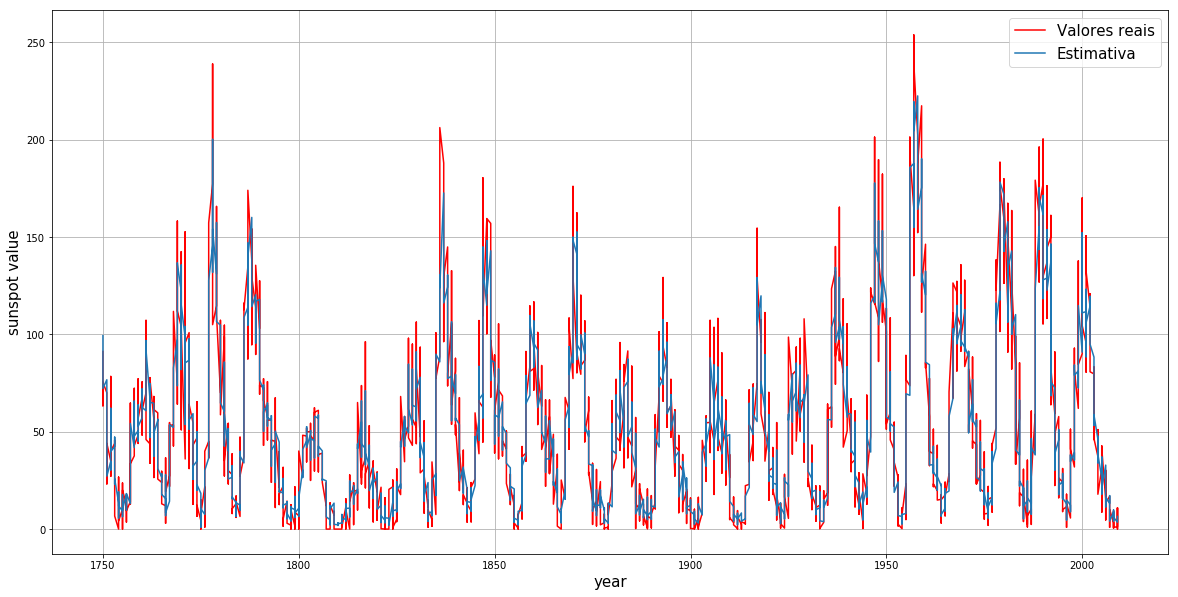

In [13]:
# Plota os valores do treinamento e suas respectivas aproximações
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(years_train[20:], sunspots_values_train[20:], 'r', label="Valores reais")
plt.plot(years_train[20:], np.dot(phi,w), label="Estimativa")
plt.legend(fontsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('sunspot value', fontsize=15)
plt.show()

In [14]:
last_train_subset = sunspots_values_train[-20:]
# Obtem os valores previstos com base nos parâmetros W, prevendo os próximos 60 valores
# Utilizando 20 atrasos
predictions = predict_x_next(last_train_subset, sunspots_values_test, w, 60, 20)


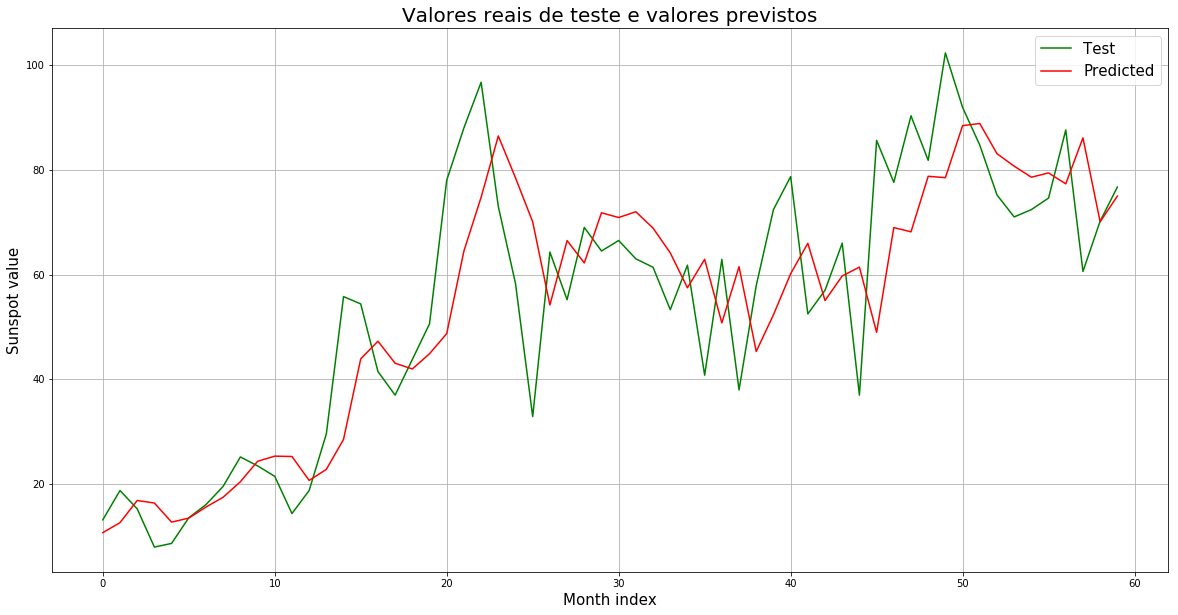

In [15]:
# Plota os valores de testes (Verde) e suas respetivas predições (vermelho)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(range(60), sunspots_values_test, 'g', label='Test')
plt.plot(range(60), predictions, 'r', label='Predicted')
plt.legend(fontsize=15)
plt.ylabel('Sunspot value', fontsize=15)
plt.xlabel('Month index', fontsize=15)
plt.title('Valores reais de teste e valores previstos', fontsize=20)
plt.show()



In [16]:
# Define a função para cálculo do RMSE
rmse = lambda predictions, sunspots_values_test: np.sqrt(np.sum((predictions - sunspots_values_test)**2) /len(predictions))

# Calcula o erro
error_without_techniques = rmse(predictions, sunspots_values_test)
# Calcula os valores estimados para o treino
train_estimator = np.dot(phi, w)

print('Train error: {}'.format(rmse(train_estimator, y)))

print("Test error: {}".format(error_without_techniques))

Train error: 15.3702320885
Test error: 14.2494511127


## Backward elimination + Normalization + K-Fold

In [17]:
phi = generate_phi(_df.values[:-60,1], 20)
y = generate_y(_df.values[:-60,1], 20)

x_fold, y_fold = k_fold(phi, y, FOLDS_NUMBER)
alphas = [ 10 ** i for i in range(-6, 4)]
alphas.append(0)
alphas

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 0]

In [18]:
errors_all_features = [ compute_error_k_fold(x_fold, y_fold, alpha) for alpha in alphas]
avg_error_all_features = np.min(errors_all_features)
alpha_min_error_for_all_features = [alphas[np.argmin(errors_all_features)]]

In [19]:
print("Error with all features: {}".format(avg_error_all_features))
print('==='*25)
indexes_remaining = range(1, 21)
number_total_features = 20

phi_iter = phi
last_error = avg_error_all_features

error_history = [avg_error_all_features]
phi_hist = []
while number_total_features > 0:
    
    min_error_for_all_features = []

    for i in range(0, number_total_features):
        # Remove a feature i
        phi_updated = remove_feature(phi_iter, i)
        # Cria os folds
        x_fold, y_fold = k_fold(phi_updated, y, 10)
        # Cada posição = média do erro para o parâmetro alpha
        alpha_errors = [ compute_error_k_fold(x_fold, y_fold, alpha) for alpha in alphas]
        # Obtem o erro mínimo para todos os valores de Alpha e para a feature I removida
        min_error = np.min(alpha_errors)
        # Obtem o alpha utilizado para obter o menor erro
        alpha_min_error = alphas[np.argmin(alpha_errors)]
        # Adiciona em um vetor de erros mínimos para todas as features
        min_error_for_all_features.append(min_error)
        # Adiciona o alpha utilizado para obter o menor erro
        alpha_min_error_for_all_features.append(alpha_min_error)

    
    # Pega o índice do mínimo erro de todas as features eliminadas
    index_to_remove = np.argmin(min_error_for_all_features)
    # Deleta a feature do vetor phi
    phi_iter = remove_feature(phi_iter, index_to_remove)
    number_total_features -= 1
    phi_hist.append(phi_iter)
    indexes_remaining = np.delete(indexes_remaining, index_to_remove)
    print('Index #{} was removed.\t\tMin error: {}\tLambda: {}\tLen: {}'.format(index_to_remove, min_error_for_all_features[index_to_remove] , round(alpha_min_error_for_all_features[index_to_remove], 4), number_total_features))
    print('Features: {}'.format(indexes_remaining))
    error_history.append(min_error_for_all_features[index_to_remove])
    


Error with all features: 15.4626867227
Index #6 was removed.		Min error: 15.3330435015	Lambda: 1000.0	Len: 19
Features: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20]
Index #10 was removed.		Min error: 15.3197438168	Lambda: 1000.0	Len: 18
Features: [ 1  2  3  4  5  6  8  9 10 11 13 14 15 16 17 18 19 20]
Index #12 was removed.		Min error: 15.3070856408	Lambda: 1000.0	Len: 17
Features: [ 1  2  3  4  5  6  8  9 10 11 13 14 16 17 18 19 20]
Index #13 was removed.		Min error: 15.2981515104	Lambda: 1000.0	Len: 16
Features: [ 1  2  3  4  5  6  8  9 10 11 13 14 16 18 19 20]
Index #10 was removed.		Min error: 15.2938367411	Lambda: 1000.0	Len: 15
Features: [ 1  2  3  4  5  6  8  9 10 11 14 16 18 19 20]
Index #10 was removed.		Min error: 15.2870308963	Lambda: 1000.0	Len: 14
Features: [ 1  2  3  4  5  6  8  9 10 11 16 18 19 20]
Index #8 was removed.		Min error: 15.2845727959	Lambda: 1000.0	Len: 13
Features: [ 1  2  3  4  5  6  8  9 11 16 18 19 20]
Index #11 was removed.		Min error: 15.2

Quando em Phi, somente resta o bias, o erro é enorme.

Através da saída anterior, é possível notar que o melhor conjunto de características é:

[ 1  2  3  4  5  6  8  9 11 16 18 20] (Len: 12)

Apresentando um erro na validação de 15.2826133986

Onde 0 representa o atraso de 1 mês anterior, 1 o atraso de 2 meses anteriores e assim respectivamente.

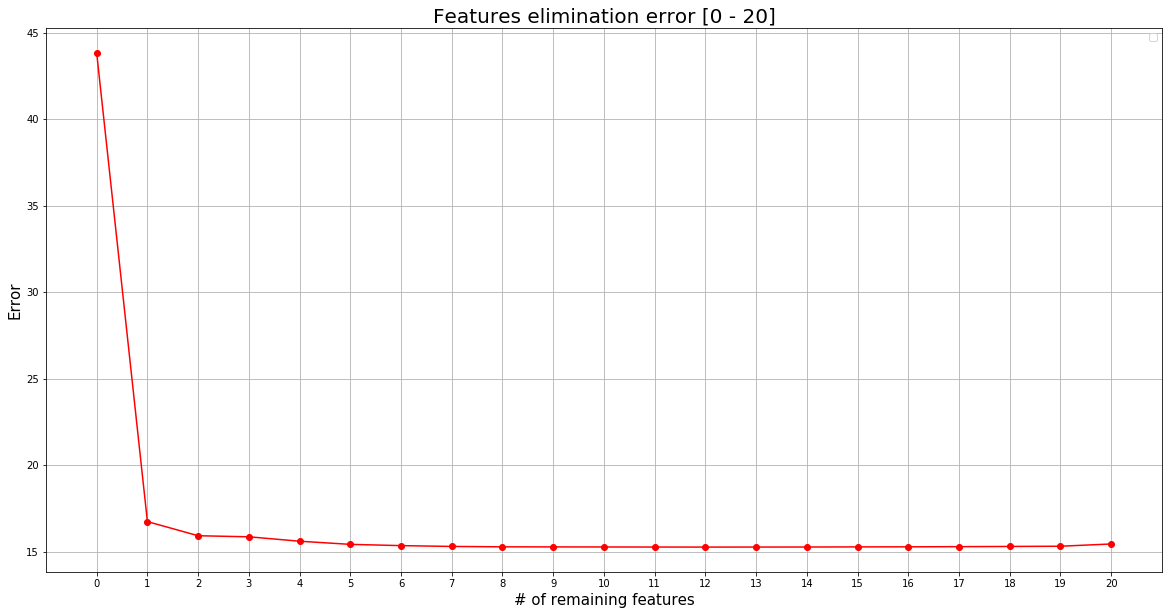

In [20]:
index = np.arange(20,-1, -1)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(index, error_history, marker='o', color='r') 
#plt.plot(12, error_history[11], marker='o', color='g') 
plt.xlabel('# of remaining features', fontsize=15)
plt.ylabel('Error', fontsize=15) 
plt.title('Features elimination error [0 - 20]', fontsize=20)
plt.xticks(index, index)
plt.legend()
plt.show()

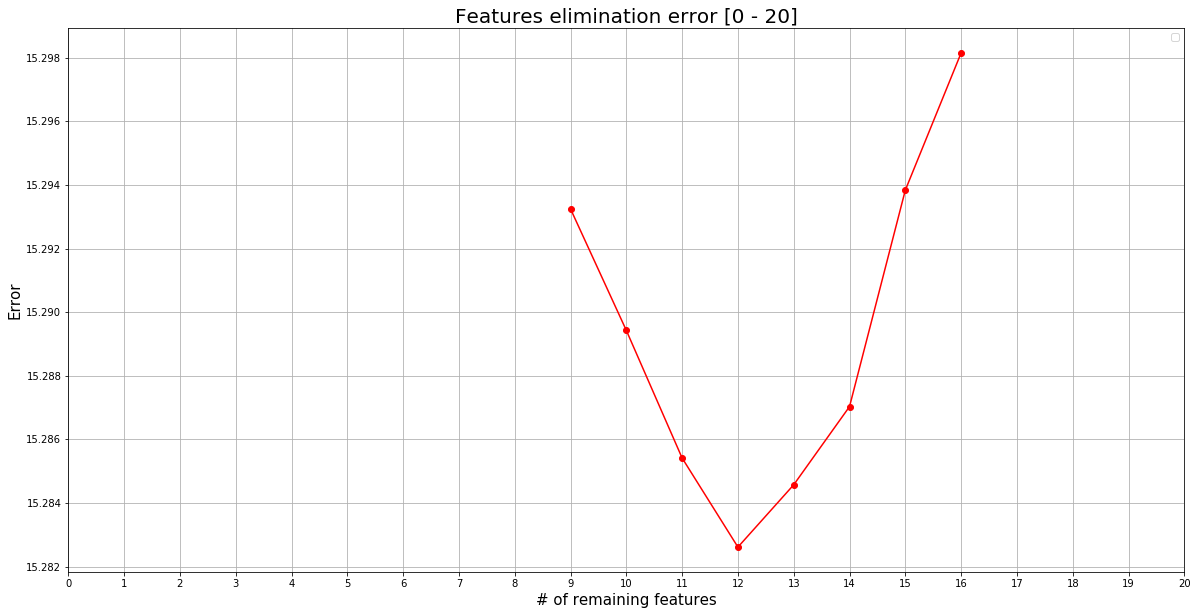

In [21]:
index = np.arange(20,-1, -1)
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(index[4:12], error_history[4:12], marker='o', color='r') 
plt.xlabel('# of remaining features', fontsize=15)
plt.ylabel('Error', fontsize=15) 
plt.title('Features elimination error [0 - 20]', fontsize=20)
plt.xticks(index, index)
plt.legend() 
plt.show()

In [22]:
# Obtém o phi com o menor erro
phi_best_feats = phi_hist[-13]
# Adiciona o BIAS ao phi
phi_best_feats = np.insert(phi_best_feats, 0, 1, axis=1)
# Cálculo do W através da solução fechada
w = np.dot(np.dot(np.linalg.inv(np.dot(phi_best_feats.T, phi_best_feats)), phi_best_feats.T), y)

# Computa e mostra o erro de treinamento
print('Train error: {}'.format(rmse(np.dot(phi_best_feats,w), y)))
# Obtém os últimos 20 valores do treinamento para prever o primeiro mês
last_train_subset = sunspots_values_train[-20:]
# Calcula as previsões para os próximos 60 meses
predictions = predict_x_next(last_train_subset, sunspots_values_test, w, 60, 20, [6, 10, 12, 13, 10, 10, 8, 11])
# Cálculo do erro do wrapper
error_wrapper = rmse(predictions, sunspots_values_test)
# Mostra o erro de teste
print("Test error: {}".format(rmse(predictions, sunspots_values_test)))



Train error: 15.3831026193
Test error: 14.1362361878


## Correlação de Pearson

In [23]:
phi = generate_phi(_df.values[:-60,1], 20)
y = generate_y(_df.values[:-60,1], 20)

x_mean = np.mean(phi)
y_mean = np.mean(y)

In [24]:
sum_x = 0
sum_y = 0

sum_x_sqr = 0
sum_y_sqr = 0

for feature in range(20):
    for i in range(phi.shape[0]):
        sum_x += (phi[i][feature] - x_mean) * (y[i] - y_mean)

        sum_x_sqr += (phi[i][feature] - x_mean)**2
        sum_y_sqr += (y[i] - y_mean)**2

    correlation = sum_x/(np.sqrt(sum_x_sqr) * np.sqrt(sum_y_sqr))

    print('Month: {}\t\tCorrelation: {}'.format(feature + 1, correlation))

Month: 1		Correlation: 0.924512774686
Month: 2		Correlation: 0.909339698622
Month: 3		Correlation: 0.89956242328
Month: 4		Correlation: 0.891765376075
Month: 5		Correlation: 0.884287375671
Month: 6		Correlation: 0.877172645402
Month: 7		Correlation: 0.869570919806
Month: 8		Correlation: 0.86221322249
Month: 9		Correlation: 0.855409817381
Month: 10		Correlation: 0.848071081016
Month: 11		Correlation: 0.840189270942
Month: 12		Correlation: 0.831664583594
Month: 13		Correlation: 0.822476811821
Month: 14		Correlation: 0.813073881542
Month: 15		Correlation: 0.803253883374
Month: 16		Correlation: 0.792670857382
Month: 17		Correlation: 0.781653982614
Month: 18		Correlation: 0.770042712856
Month: 19		Correlation: 0.758209293557
Month: 20		Correlation: 0.746058723002


Pode-se notar que a correlação dos meses mais recentes, é mais importante para prever o valor do próximo mês.

Utilizando o Wrapper, as features escolhidas foram:

[ 1  2  3  4  5  6  8  9 11 16 18 20] (12 features)

Através da correlação de Pearson, definimos as 12 features com maior correlação, sendo assim, temos:

[ 1  2  3  4  5  6  7  8  9  10  11  12] (12 features)

Onde, o índice 1 representa o valor de 1 mês anterior, 2 representa o valor de 2 meses anteriores e assim sucessivamemnte.

In [25]:
# Cada entrada da matriz phi se torna apenas as 9 primeiras features
_phi = phi[:,:12]
# Adiciona o bias
_phi = np.insert(_phi, 0, 1, axis=1)

x_fold, y_fold = k_fold(phi, y, FOLDS_NUMBER)
error_filter = [ compute_error_k_fold(x_fold, y_fold, alpha) for alpha in alphas]
error_filter = np.min(error_filter)
alpha_min_error_for_all_features = [alphas[np.argmin(errors_all_features)]]


In [26]:
print('Test Error without any techniques: {}'.format(error_without_techniques))
print('Test Error with wrapper: {}'.format(error_wrapper))
print('Test Error with filter: {}'.format(error_filter))

Test Error without any techniques: 14.2494511127
Test Error with wrapper: 14.1362361878
Test Error with filter: 15.4626867227


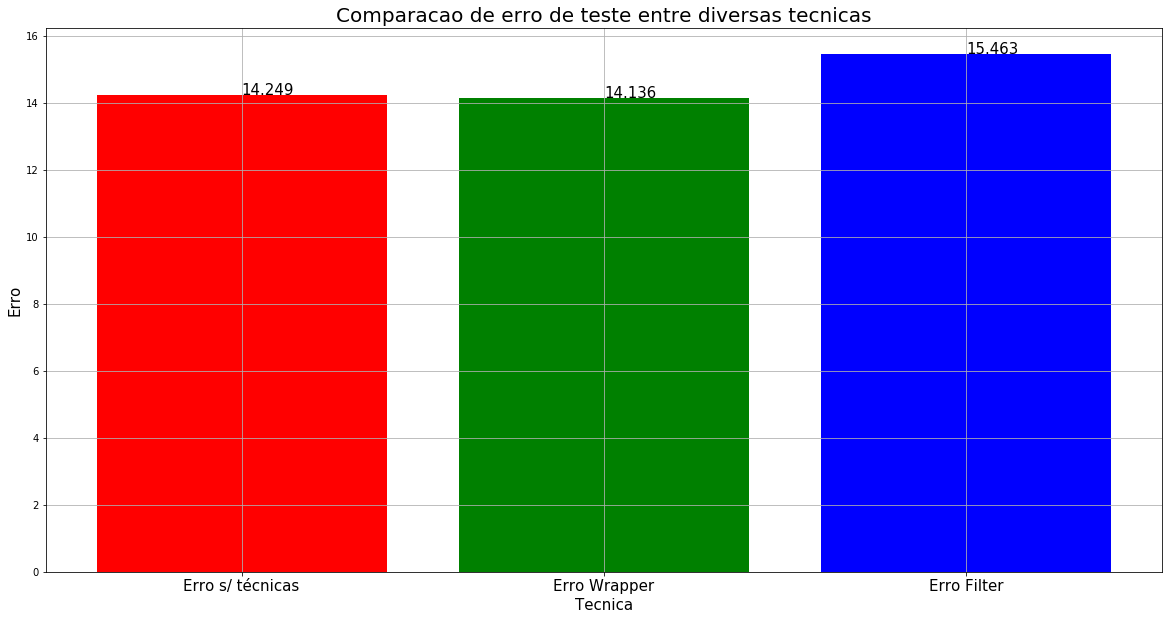

In [27]:
# Configuração da visualização de comparação entre erros
plt.figure(figsize=(20,10))
plt.grid(True)
plt.bar(['Erro s/ técnicas'], [error_without_techniques], color='r')
plt.bar(['Erro Wrapper'], [error_wrapper], color='g')
plt.bar(['Erro Filter'], [error_filter], color='b')
plt.xticks(fontsize=15)
plt.title('Comparacao de erro de teste entre diversas tecnicas', fontsize=20)
plt.xlabel('Tecnica',fontsize=15)
plt.ylabel('Erro',fontsize=15)
plt.text(0,error_without_techniques,round(error_without_techniques, 3), fontsize=15)
plt.text(1,error_wrapper, round(error_wrapper, 3), fontsize=15)
plt.text(2,error_filter, round(error_filter, 3), fontsize=15)
plt.show()

Podemos observar, que apesar de utilizar as 12 features com maior correlação em respeito ao valor que deve-se prever, o desempenho em termo de erro do teste utilizando esta abordagem, é pior que o erro sem aplicar nenhuma técnica.

A correlação de Pearson mede apenas a correlação entre uma variável de entrada, e seu rótulo. 

A técnica wrapper, consegue identificar a correlação entre um conjunto de features e seu rótulo.

Neste caso, apenas a correlação independente de cada variável de entrada pode resultar em um erro que pode ser diminuído ainda mais por outras técnicas.